# Plotting animated GIFs from time series imagery

**What does this notebook do?** 

This notebook demonstrates how to import a time series of DEA cloud-free Landsat imagery from multiple sensors (i.e. Landsat 5, 7 and 8) as an xarray dataset, and then plot the data as an animated time series GIF and a transitioning/fading GIF that compares two timesteps. Animations can be produced as either GIFs or MP4s for any area in Australia using a standard datacube query.

**Required inputs**

This example uses three external functions called `load_clearlandsat`, `animated_timeseries` and `animated_fade`. These functions are available in the Scripts folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** May 2018

**Author:** Robbi Bishop-Taylor

In [1]:
# Import modules
import datacube 
import sys
import os

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../Scripts')
import DEADataHandling
import DEAPlotting

# Set up datacube instance
dc = datacube.Datacube(app='Time series animation')

## Set up datacube query
Define the query bounds for datacube extraction using a dict. This should include `x` and `y` limits, potentially a list of `measurements` (i.e. the bands you want to extract like 'red', 'green', 'blue'; this significantly speeds up the import) and a `time` extent. If no `time` is given, the function defaults to all timesteps available to all sensors (e.g. 1987-2018).

In [ ]:
# Set up spatial and temporal query.
query = {'x': (970476, 987476),
         'y': (-3568950, -3551951),
         'measurements': ['red', 'green', 'blue'],
         'time': ('2013-01-01', '2018-01-01'),
         'crs': 'EPSG:3577'}

In [36]:
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Set up analysis data query using a buffer around a lat-long point
lat, lon = -36.4996246273, 148.30277941
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - 6000, x + 6000),
         'y': (y - 6000, y + 6000),   
         'measurements': ['red', 'green', 'blue', 'swir1'],
         'time': ('2005-01-01', '2018-01-01'),
         'crs': 'EPSG:3577'}

## Extract cloud-free clear Landsat observations from all sensors
Use the `load_clearlandsat` function to load Landsat observations and PQ data for multiple sensors (i.e. ls5, ls7, ls8), and return a single xarray dataset containing only observations that contain greater than a specified proportion of clear pixels. This uses `dask` to only load in the filtered observations, and results in a visually appealing time series of observations that are not affected by cloud!

Loading ls5 PQ
    Loading 76 filtered ls5 timesteps
Loading ls7 PQ
    Loading 0 filtered ls7 timesteps
Loading ls8 PQ
    Loading 46 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
<xarray.Dataset>
Dimensions:    (time: 122, x: 481, y: 481)
Coordinates:
  * y          (y) float64 -4.076e+06 -4.076e+06 -4.076e+06 -4.076e+06 ...
  * x          (x) float64 1.453e+06 1.453e+06 1.453e+06 1.453e+06 1.453e+06 ...
  * time       (time) datetime64[ns] 2005-01-06T23:36:41.500000 ...
Data variables:
    red        (time, y, x) float64 649.0 649.0 623.0 649.0 598.0 624.0 ...
    green      (time, y, x) float64 610.0 578.0 547.0 547.0 547.0 578.0 ...
    blue       (time, y, x) float64 422.0 390.0 359.0 406.0 391.0 391.0 ...
    swir1      (time, y, x) float64 2.211e+03 2.104e+03 1.955e+03 1.976e+03 ...
    data_perc  (time) float64 0.9661 1.0 0.9976 1.0 0.9713 0.9938 1.0 0.9213 ...
Attributes:
    crs:      EPSG:3577


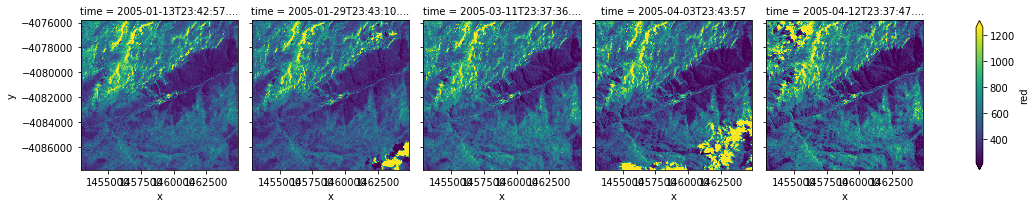

In [37]:
import xarray as xr
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking


def load_clearlandsat(dc, query, masked_prop=0.99, sensors=['ls5', 'ls7', 'ls8'], mask_dict=None):
    
    """
    Loads Landsat observations and PQ data for multiple sensors (i.e. ls5, ls7, ls8), and returns a
    single xarray dataset containing only observations that contain greater than a specified proportion
    of clear pixels.
    
    This may be useful for extracting a visually appealing time series of observations that are not
    affected by cloud, for example as an input to the `animated_timeseries` function from `DEAPlotting`.
    
    Last modified: May 2018
    Author: Robbi Bishop-Taylor
    
    :param dc: 
        A specific Datacube instance to import from, i.e. `dc = datacube.Datacube(app='Clear Landsat')`. 
        This allows you to also use dev environments if thay have been imported into the environment.
        
    :param query: 
        A dict containing the query bounds. Can include lat/lon, time, measurements etc. If no `time`
        query is given, the function defaults to all timesteps available to all sensors (e.g. 1987-2018)
        
    :param masked_prop:
        A float giving the minimum percentage of clear pixels required for a Landsat observation to be 
        loaded. Defaults to 0.99 (i.e. only return observations with less than 1% of unclear pixels).
        
    :param sensors:
        A list of Landsat sensor names to load data for. Options are 'ls5', 'ls7', 'ls8', defaults to all.
        
    :param mask_dict:
        An optional dict of arguments to the `masking.make_mask` function that can be used to generate a mask
        from the PQ layer using alternative masking criteria. The default value of None masks out pixels
        flagged as cloud by either the ACCA or Fmask alogorithms, and that have values for every band 
        (equivalent to: `mask_dict={'cloud_acca': 'no_cloud', 'cloud_fmask': 'no_cloud', 'contiguous': True}`.
        See the `Landsat5-7-8-PQ` notebook on DEA Notebooks for a list of all possible options.
    
    :returns:
        An xarray dataset containing only Landsat observations that contain greater than `masked_prop`
        proportion of clear pixels.  
        
    :example:
    
    >>> # Import modules
    >>> import datacube     
    >>> 
    >>> # Set up datacube instance
    >>> dc = datacube.Datacube(app='Clear Landsat')
    >>> 
    >>> # Set up spatial and temporal query.
    >>> query = {'x': (-191399.7550998943, -183399.7550998943),
    >>>          'y': (-1423459.1336905062, -1415459.1336905062),
    >>>          'measurements': ['red', 'green', 'blue'],
    >>>          'time': ('2013-01-01', '2018-01-01'),
    >>>          'crs': 'EPSG:3577'}
    >>> 
    >>> # Load in only clear Landsat observations with < 1% unclear values
    >>> combined_ds = load_clearlandsat(dc=dc, query=query, masked_prop=0.99) 
    >>> combined_ds
        
    """
    

    # List to save results from each sensor
    filtered_sensors = []

    # Iterate through all sensors, returning only observations with > mask_prop clear pixels
    for sensor in sensors:
        
        try:

            # Lazily load Landsat data using dask
            print('Loading {} PQ'.format(sensor))
            data = dc.load(product = '{}_nbar_albers'.format(sensor),
                        group_by = 'solar_day', 
                        dask_chunks={'time': 1},
                        **query)

            # Remove measurements variable from query so that PQ load doesn't fail
            pq_query = query.copy()
            if 'measurements' in pq_query: del pq_query['measurements']

            # Load PQ data
            pq = dc.load(product = '{}_pq_albers'.format(sensor),
                         group_by = 'solar_day',
                         fuse_func=ga_pq_fuser,
                         **pq_query)

            # Return only Landsat observations that have matching PQ data (this may
            # need to be improved, but seems to work in most cases)
            data = data.sel(time = pq.time, method='nearest')
            
            # If a custom dict is provided for mask_dict, use these values to make mask from PQ
            if mask_dict:
                
                # Mask PQ using custom values by unpacking mask_dict **kwarg
                good_quality = masking.make_mask(pq.pixelquality, **mask_dict)
                
            else:

                # Identify pixels with no clouds in either ACCA for Fmask
                good_quality = masking.make_mask(pq.pixelquality,
                                                 cloud_acca='no_cloud',
                                                 cloud_fmask='no_cloud',
                                                 contiguous=True)

            # Compute good data for each observation as a percentage of total array pixels
            data_perc = good_quality.sum(dim=['x', 'y']) / (good_quality.shape[1] * good_quality.shape[2])
            
            # Add data_perc data to Landsat dataset as a new xarray variable
            data['data_perc'] = xr.DataArray(data_perc, [('time', data.time)])

            # Filter and finally import data using dask
            filtered = data.where(data.data_perc >= masked_prop, drop=True)
            print('    Loading {} filtered {} timesteps'.format(len(filtered.time), sensor))
            filtered = filtered.compute()
            
            # Append result to list
            filtered_sensors.append(filtered)
        
        except:
            
            # If there is no data for sensor or if another error occurs:
            print('    Skipping {}'.format(sensor))

    # Concatenate all sensors into one big xarray dataset, and then sort by time
    print('Combining and sorting ls5, ls7 and ls8 data')
    combined_ds = xr.concat(filtered_sensors, dim='time')
    combined_ds = combined_ds.sortby('time')
    
    # Return combined dataset
    return combined_ds


# Set the minimum proportion of clear pixels (pixels with no clouds or other nodata)
masked_prop=0.90

# Load in only clear Landsat observations with < 1% unclear values
combined_ds = load_clearlandsat(dc=dc, query=query, masked_prop=masked_prop, mask_dict={'cloud_fmask': 'no_cloud', 'contiguous': True})  
print(combined_ds)

# Plot first five time series images (just using the red band for simplicity):
combined_ds.red.isel(time=[1, 2, 3, 4, 5]).plot(col="time", robust=True)

## Plot entire time series as an animated GIF
The `animated_timeseries` function takes an xarray time series and exports a three band (e.g. true or false colour) GIF or MP4 animation showing changes in the landscape across time. Here, we plot the xarray as an animated GIF that includes a date annotation for each frame. We set the interval between the animation frames to 80 milliseconds, and set `reflect_stand=2500` to use a bright and vibrant colour stretch:

In [103]:
# Remove dodgy images
times_to_drop = combined_ds.red.loc['1991-01-30':'1991-02-02'].time.values
times_to_drop2 = combined_ds.red.loc['1997-01-30':'1997-02-02'].time.values
combined_ds_subset = combined_ds.drop(times_to_drop, dim="time")
combined_ds_subset = combined_ds_subset.drop(times_to_drop2, dim="time")
combined_ds_subset


# # Produce time series animation of red, green and blue bands
# DEAPlotting.animated_timeseries(ds=combined_ds_hs, output_path="/home/561/rt1527/Transfer/animated_timeseries_thredbo.mp4", 
#                                 interval=100, reflect_stand=2500, width_pixels=600) 

<xarray.Dataset>
Dimensions:    (time: 122, x: 481, y: 481)
Coordinates:
  * y          (y) float64 -4.076e+06 -4.076e+06 -4.076e+06 -4.076e+06 ...
  * x          (x) float64 1.453e+06 1.453e+06 1.453e+06 1.453e+06 1.453e+06 ...
  * time       (time) datetime64[ns] 2005-01-06T23:36:41.500000 ...
Data variables:
    red        (time, y, x) float64 649.0 649.0 623.0 649.0 598.0 624.0 ...
    green      (time, y, x) float64 610.0 578.0 547.0 547.0 547.0 578.0 ...
    blue       (time, y, x) float64 422.0 390.0 359.0 406.0 391.0 391.0 ...
    swir1      (time, y, x) float64 2.211e+03 2.104e+03 1.955e+03 1.976e+03 ...
    data_perc  (time) float64 0.9661 1.0 0.9976 1.0 0.9713 0.9938 1.0 0.9213 ...
Attributes:
    crs:      EPSG:3577

/g/data/v10/public/modules/dea/20180515/lib/python3.6/site-packages/datacube/api/query.py:92: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if like:


Generating animation with 122 frames
    Exporting animation to /home/561/rt1527/Transfer/animated_timeseries_thredbo.mp4


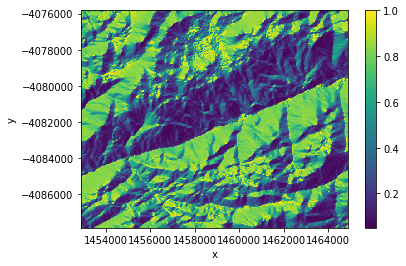

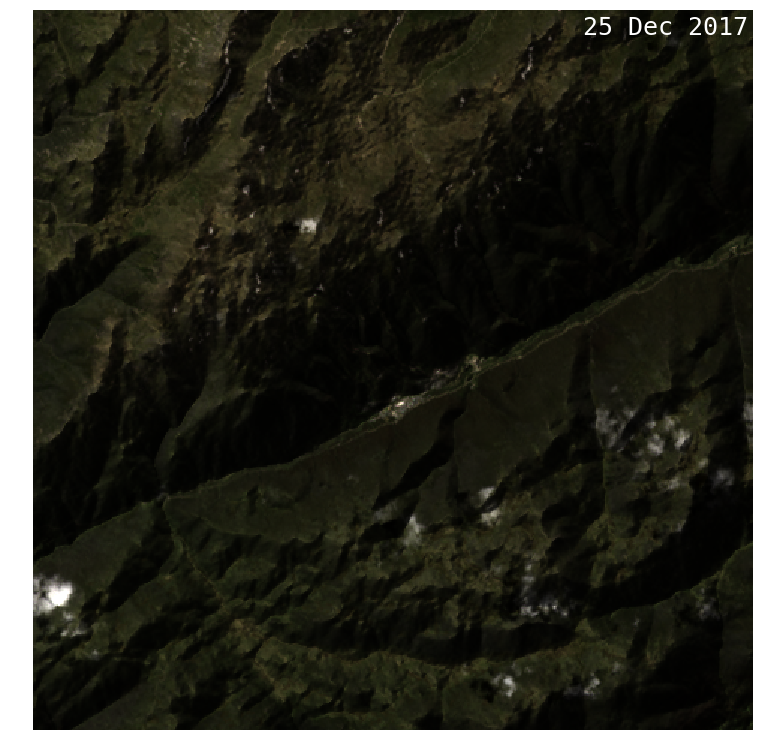

In [105]:
import numpy as np
import xarray as xr

def hillshade(array,azimuth,angle_altitude):
    
    # http://neondataskills.org/lidar/create-hillshade-py/
    
    azimuth = 360.0 - azimuth 
    
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.
 
    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)
    
    return 255.0*(shaded + 1)/2.0



dem_ds = dc.load(product='srtm_dem1sv1_0', like=combined_ds_subset, resampling='bilinear') 
array = dem_ds.dem.isel(time=0).values
hillshade_array = hillshade(array, 315, 50)
hs_dataarray = xr.DataArray(hillshade_array, [dem_ds.coords['y'], dem_ds.coords['x']])
hs_dataarray

# Rescale
hs_rescaled = (hs_dataarray - hs_dataarray.min()) / (hs_dataarray.max() - hs_dataarray.min()) * (1.0 - 0.05) + 0.05
hs_rescaled.plot()
combined_ds_hs = (combined_ds_subset * hs_rescaled)

# Produce time series animation of red, green and blue bands
DEAPlotting.animated_timeseries(ds=combined_ds_hs, output_path="/home/561/rt1527/Transfer/animated_timeseries_thredbo.mp4", 
                                interval=100, reflect_stand=2500, width_pixels=600) 



In [ ]:
import gc
gc.collect()

## Plot fading/transitioning animation to compare two timesteps
The `animated_fade` function takes two single-timestep xarray datasets, and plots an animation of the two layers fading between each other. This may be useful for comparing an area before and after environmental change (i.e. flood, drought, fire, development), or comparing two different geographic areas. Here, we compare a dry and a wet timestep, and use the `endpoint_text` parameter to annotate the two images:

In [ ]:
# Extract xarray datasets for two timesteps
ds1 = combined_ds.isel(time=1)
ds2 = combined_ds.isel(time=30)

# Produce animation that fades between ds1 and ds2
DEAPlotting.animated_fade(ds1=ds1, ds2=ds2, 
                          output_path='animated_fade.gif', 
                          reflect_stand=2500,
                          endpoint_text=['Dry timestep',  'Wet timestep'])